# Intro. to Snorkel: Extracting Spouse Relations from the News

## Part IV: Training a Model with Data Programming

In this part of the tutorial, we will train a statistical model to differentiate between true and false `Spouse` mentions.

We will train this model using _data programming_, and we will **ignore** the training labels provided with the training data. This is a more realistic scenario; in the wild, hand-labeled training data is rare and expensive. Data programming enables us to train a model using only a modest amount of hand-labeled data for validation and testing. For more information on data programming, see the [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We repeat our definition of the `Spouse` `Candidate` subclass from Parts II and III.

In [2]:
from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

## Loading `CandidateSet` objects

We reload the training and development `CandidateSet` objects from the previous parts of the tutorial.

In [3]:
from snorkel.models import CandidateSet

train = session.query(CandidateSet).filter(CandidateSet.name == 'News Training Candidates').one()
dev = session.query(CandidateSet).filter(CandidateSet.name == 'News Development Candidates').one()

## Automatically Creating Features
Recall that our goal is to distinguish between true and false mentions of spouse relations. To train a model for this task, we first embed our `Spouse` candidates in a feature space.

In [4]:
from snorkel.annotations import FeatureManager

feature_manager = FeatureManager()

We can create a new feature set:

In [5]:
%time F_train = feature_manager.create(session, train, 'Train Features')

[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 11min 55s, sys: 7.09 s, total: 12min 2s
Wall time: 12min 20s


**OR** if we've already created one, we can simply load as follows:

In [6]:
%time F_train = feature_manager.load(session, train, 'Train Features')

CPU times: user 4.1 s, sys: 129 ms, total: 4.23 s
Wall time: 4.26 s


Note that the returned matrix is a special subclass of the `scipy.sparse.csr_matrix` class, with some special features which we demonstrate below:

In [7]:
F_train

<4698x115172 sparse matrix of type '<type 'numpy.float64'>'
	with 272417 stored elements in Compressed Sparse Row format>

In [8]:
F_train.get_candidate(0)

Spouse(Span("Elijah E. Cummings", parent=15829, chars=[17,34], words=[3,5]), Span("Obama", parent=15829, chars=[137,141], words=[23,23]))

In [9]:
F_train.get_key(0)

AnnotationKey (TDL_LEMMA:PARENTS-OF-BETWEEN-MENTION-and-MENTION[None])

## Creating Labeling Functions
Labeling functions are a core tool of data programming. They are heuristic functions that aim to classify candidates correctly. Their outputs will be automatically combined and denoised to estimate the probabilities of training labels for the training data.

In [10]:
import re
from snorkel.lf_helpers import get_left_tokens, get_right_tokens, get_between_tokens, get_text_between

## Applying Labeling Functions

First we construct a `LabelManager`.

In [11]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

Next we run the `LabelManager` to to apply the labeling functions to the training `CandidateSet`.  We'll start with some of our labeling functions:

In [12]:
spouses = {'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

def LF_too_far_apart(c):
    return -1 if len(get_between_tokens(c)) > 10 else 0

def LF_third_wheel(c):
    return -1 if 'PERSON' in get_between_tokens(c, attrib='ner_tags', case_sensitive=True) else 0
    
def LF_husband_wife(c):
    return 1 if len(spouses.intersection(set(get_between_tokens(c)))) > 0 else 0

def LF_husband_wife_left_window(c):
    if len(spouses.intersection(set(get_left_tokens(c[0], window=2)))) > 0:
        return 1
    elif len(spouses.intersection(set(get_left_tokens(c[1], window=2)))) > 0:
        return 1
    else:
        return 0

def LF_no_spouse_in_sentence(c):
    return -1 if len(spouses.intersection(set(c[0].parent.words))) == 0 else 0

def LF_and_married(c):
    return 1 if 'and' in get_between_tokens(c) and 'married' in get_right_tokens(c) else 0
    
def LF_familial_relationship(c):
    return -1 if len(set(family).intersection(set(get_between_tokens(c)))) > 0 else 0

def LF_family_left_window(c):
    if len(family.intersection(set(get_left_tokens(c[0], window=2)))) > 0:
        return -1
    elif len(family.intersection(set(get_left_tokens(c[1], window=2)))) > 0:
        return -1
    else:
        return 0

def LF_other_relationship(c):
    coworker = ['boss', 'employee', 'secretary', 'co-worker']
    return -1 if len(set(coworker).intersection(set(get_between_tokens(c)))) > 0 else 0

In [13]:
LFs = [LF_too_far_apart, LF_third_wheel, LF_husband_wife, LF_husband_wife_left_window,
       LF_and_married, LF_familial_relationship, LF_other_relationship]

In [14]:
%time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 49.3 s, sys: 809 ms, total: 50.1 s
Wall time: 50.5 s


<4698x7 sparse matrix of type '<type 'numpy.float64'>'
	with 3570 stored elements in Compressed Sparse Row format>

**OR** load if we've already created:

In [15]:
%time L_train = label_manager.load(session, train, 'LF Labels')
L_train

CPU times: user 108 ms, sys: 2.41 ms, total: 111 ms
Wall time: 118 ms


<4698x7 sparse matrix of type '<type 'numpy.float64'>'
	with 3570 stored elements in Compressed Sparse Row format>

We can also add or rerun a single labeling function (or more!) with the below command. Note that we set the argument `expand_key_set` to `True` to indicate that the set of matrix columns should be allowed to expand:

In [16]:
L_train = label_manager.update(session, train, 'LF Labels', True, f=[LF_no_spouse_in_sentence])
L_train

[========================================] 100%

Loading sparse Label matrix...


<4698x8 sparse matrix of type '<type 'numpy.float64'>'
	with 7930 stored elements in Compressed Sparse Row format>

We can view statistics about the resulting label matrix:

In [17]:
L_train.lf_stats()

,conflicts,coverage,j,overlaps
LF_too_far_apart,0.016603,0.279268,0,0.276926
LF_third_wheel,0.021499,0.379736,1,0.375692
LF_husband_wife,0.018519,0.025117,2,0.024053
LF_husband_wife_left_window,0.014900,0.029161,3,0.020434
LF_and_married,0.000213,0.000213,4,0.000213
LF_familial_relationship,0.006386,0.040230,5,0.037463
LF_other_relationship,0.000000,0.006173,6,0.006173
LF_no_spouse_in_sentence,0.000213,0.928054,7,0.458067


## Fitting the Generative Model
We estimate the accuracies of the labeling functions without supervision. Specifically, we estimate the parameters of a `NaiveBayes` generative model.

In [18]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=1000, rate=1e-5)

Training marginals (!= 0.5):	4698
Features:			8
Begin training for rate=1e-05, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.414672
	Learning epoch = 250	Gradient mag. = 0.436693
	Learning epoch = 500	Gradient mag. = 0.436889
	Learning epoch = 750	Gradient mag. = 0.437085
Final gradient magnitude for rate=1e-05, mu=1e-06: 0.437


/Users/bradenhancock/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [19]:
gen_model.save(session, 'Generative Params')

We now apply the generative model to the training candidates.

In [20]:
train_marginals = gen_model.marginals(L_train)

In [21]:
gen_model.w

array([ 1.00215399,  1.0025843 ,  0.99987012,  0.99992132,  0.99999873,
        1.00025635,  1.00006087,  1.00277025])

## Training the Discriminative Model
We use the estimated probabilites to train a discriminative model that classifies each `Candidate` as a true or false mention. We'll use a random hyperparameter search, evaluated on the development set labels, to find the best hyperparameters for our model. To run a hyperparameter search, we need labels for a development set. If they aren't already available, we can manually create labels using the Viewer.

In [22]:
from snorkel.learning import LogReg
from snorkel.learning_utils import RandomSearch, ListParameter, RangeParameter

iter_param = ListParameter('n_iter', [250, 500, 1000, 2000])
rate_param = RangeParameter('rate', 1e-4, 1e-2, step=0.75, log_base=10)
reg_param  = RangeParameter('mu', 1e-8, 1e-2, step=1, log_base=10)

disc_model = LogReg()

First, we create features for the development set candidates.

Note that we use the training feature set, because those are the only features for which we have learned parameters. Features that were not encountered during training, e.g., a token that does not appear in the training set, are ignored, because we do not have any information about them.

To do so with the `FeatureManager`, we call update with the new `CandidateSet`, the name of the training `AnnotationKeySet`, and the value `False` for the parameter `extend_key_set` to indicate that the `AnnotationKeySet` should not be expanded with new `Feature` keys encountered during processing.

In [23]:
%time F_dev = feature_manager.update(session, dev, 'Train Features', False)

[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 24.1 s, sys: 462 ms, total: 24.5 s
Wall time: 25 s


**OR** if we've already created one, we can simply load as follows:

In [24]:
%time F_dev = feature_manager.load(session, dev, 'Train Features')

CPU times: user 2.18 s, sys: 97.1 ms, total: 2.28 s
Wall time: 2.32 s


Next, we load the development set labels and gold candidates we made in Part III.

In [25]:
L_gold_dev = label_manager.load(session, dev, "News Gold Labels")

In [26]:
gold_dev_set = session.query(CandidateSet).filter(CandidateSet.name == 'News Development Candidates').one()

Now we set up and run the hyperparameter search, training our model with different hyperparamters and picking the best model configuration to keep. We'll set the random seed to maintain reproducibility.

Note that we are fitting our model's parameters to the training set generated by our labeling functions, while we are picking hyperparamters with respect to score over the development set labels which we created by hand.

In [27]:
searcher = RandomSearch(disc_model, F_train, train_marginals, 10, iter_param, rate_param, reg_param)

In [28]:
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev, gold_dev_set)

Testing n_iter = 1.00e+03, rate = 1.00e-04, mu = 1.00e-02
Training marginals (!= 0.5):	4598
Features:			115172
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 3187.090736	Gradient magnitude = 1822.322773
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 2185.689909	Gradient magnitude = 63.544320
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 2159.912231	Gradient magnitude = 48.567846
	Learning epoch = 300	Step size = 7.40707032156e-05
	Loss = 2145.210919	Gradient magnitude = 40.411948
	Learning epoch = 400	Step size = 6.70185906007e-05
	Loss = 2135.616472	Gradient magnitude = 35.318976
	Learning epoch = 500	Step size = 6.06378944861e-05
	Loss = 2128.823323	Gradient magnitude = 31.842154
	Learning epoch = 600	Step size = 5.48646907485e-05
	Loss = 2123.752776	Gradient magnitude = 29.314160
	Learning epoch = 700	Step size = 4.96411413431e-05
	Loss = 2119.827388	Gradient magnitude = 27.394050
	Learning epoch = 800	Step size = 4.4914914861e-05

,n_iter,rate,mu,Prec.,Rec.,F1
0,1000,0.000100,1.000000e-02,0.000000,0.000000,0.000000
1,250,0.003162,1.000000e-06,0.500000,0.166667,0.250000
2,1000,0.000100,1.000000e-07,0.000000,0.000000,0.000000
3,1000,0.003162,1.000000e-08,0.600000,0.500000,0.545455
4,1000,0.003162,1.000000e-03,0.600000,0.500000,0.545455
5,2000,0.000100,1.000000e-03,1.000000,0.166667,0.285714
6,2000,0.003162,1.000000e-04,0.600000,0.500000,0.545455
7,500,0.017783,1.000000e-07,0.093023,0.666667,0.163265
8,250,0.003162,1.000000e-04,0.100000,0.500000,0.166667
9,250,0.017783,1.000000e-05,0.333333,0.166667,0.222222


_Note that to train a model without tuning any hyperparameters--at your own risk!--just use the `train` method of the discriminative model. For instance, to train with 500 iterations and a learning rate of 0.001, you could run:_
```
disc_model.train(F_train, train_marginals, n_iter=500, rate=0.001)
```

In [29]:
disc_model.w.shape

(115172,)

In [30]:
%time disc_model.save(session, "Discriminative Params")

CPU times: user 25.4 s, sys: 690 ms, total: 26.1 s
Wall time: 26.3 s


Calibration plot:


/Users/bradenhancock/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


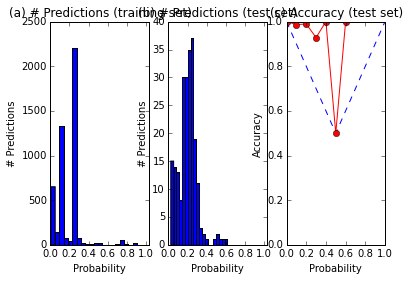

Test set size:	224
----------------------------------------
Pos. class accuracy: 0.5
Neg. class accuracy: 0.990825688073
----------------------------------------
Precision:	0.6
Recall:		0.5
F1 Score:	0.545454545455
----------------------------------------
TP: 3 | FP: 2 | TN: 216 | FN: 3
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.5
Neg. class accuracy: 0.990825688073
Corpus Precision 0.6
Corpus Recall    0.5
Corpus F1        0.545
----------------------------------------
TP: 3 | FP: 2 | TN: 216 | FN: 3



In [31]:
tp, fp, tn, fn = disc_model.score(F_dev, L_gold_dev, gold_dev_set)

## Viewing Examples
After evaluating on the development `CandidateSet`, the labeling functions can be modified. Try changing the labeling functions to improve performance. You can view the true positives, false positives, true negatives, and false negatives using the `Viewer`.

In [32]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fn, session, annotator_name="Tutorial Part IV User")
else:
    sv = None

<IPython.core.display.Javascript object>

In [33]:
sv

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Next, in Part V, we will test our model on the test `CandidateSet`.